In [1]:
import matplotlib.pyplot as plt
import networkx as nx

import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg

import json
with open("./seoul-metro.json") as f:
          data = json.load(f)

In [2]:
g = nx.Graph()

for line in data.values():
    g.add_edges_from(line["transfers"])
    g.add_weighted_edges_from(line["travel_times"])

for n1, n2 in g.edges():
    g[n1][n2]["transfer"] = "weight" not in g[n1][n2]

In [3]:
on_foot = [edge for edge in g.edges() if g.get_edge_data(*edge)["transfer"]]
on_train = [edge for edge in g.edges() if not g.get_edge_data(*edge)["transfer"]]

colors = [data[n[0].upper()]["color"] for n in g.nodes()]

In [4]:
from networkx.drawing.nx_agraph import graphviz_layout

In [5]:
%matplotlib qt

fig, ax = plt.subplots(1, 1, figsize=(20, 15))

pos = graphviz_layout(g, prog="neato")
nx.draw_networkx(g, pos, ax=ax, node_size=450, node_color=colors)
nx.draw_networkx_labels(g, pos=pos, ax=ax, font_size=1)
nx.draw_networkx_edges(g, pos=pos, ax=ax, edgelist=on_train, width=2)
nx.draw_networkx_edges(g, pos=pos, ax=ax, edgelist=on_foot, edge_color="red", width=2)

for side in ['bottom','right','top','left']:
    ax.spines[side].set_visible(False)

ax.set_xticks([])
ax.set_yticks([])
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

In [6]:
g_degree = dict(g.degree())
d_max = max(g_degree.values())
[(n,d) for (n,d) in g_degree.items() if d == d_max]

[('133', 6), ('426', 6), ('A02', 6)]

In [7]:
p = nx.shortest_path(g, "124", "319"); p

['124',
 '125',
 '126',
 '127',
 '128',
 '129',
 '130',
 '329',
 '328',
 '327',
 '326',
 '325',
 '324',
 '323',
 '322',
 '321',
 '320',
 '319']

In [8]:
np.sum([g[p[n]][p[n +1]]["weight"] for n in range(len(p) -1) if "weight" in g[p[n]][p[n +1]]])

48

In [9]:
h = g.copy()
for n1, n2 in h.edges():
    if h[n1][n2]["transfer"]:
        h[n1][n2]["weight"] = 5
p = nx.shortest_path(h, "B24", "319")
p

['B24',
 'B23',
 'B22',
 'B21',
 'B20',
 'B19',
 'B18',
 'B17',
 'B16',
 'B15',
 'B14',
 'B13',
 'B12',
 'B11',
 'B10',
 '208',
 '207',
 '206',
 '205',
 '204',
 '535',
 '534',
 '329',
 '328',
 '327',
 '326',
 '325',
 '324',
 '323',
 '322',
 '321',
 '320',
 '319']

In [10]:
np.sum([h[p[n]][p[n +1]]["weight"] for n in range(len(p) -1)])

102

In [11]:
p = nx.shortest_path(h, "A01", "K116")
np.sum([h[p[n]][p[n +1]]["weight"] for n in range(len(p) -1)])

34

In [12]:
A = nx.to_scipy_sparse_matrix(g); A

<605x605 sparse matrix of type '<class 'numpy.intc'>'
	with 1410 stored elements in Compressed Sparse Row format>

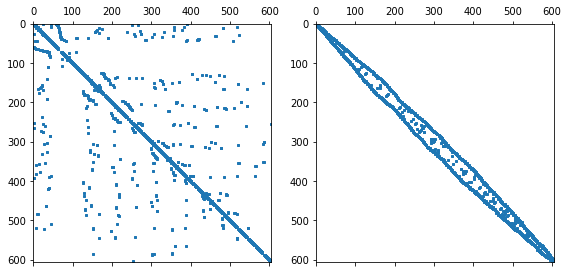

In [13]:
perm = sp.csgraph.reverse_cuthill_mckee(A)
def sp_permute(A, perm_r, perm_c):
    M, N = A.shape
    Pr = sp.coo_matrix((np.ones(M), (perm_r, np.arange(N)))).tocsr()
    Pc = sp.coo_matrix((np.ones(M), (np.arange(M), perm_c))).tocsr()
    return Pr.T *A *Pc.T

%matplotlib inline
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

ax1.spy(A, markersize=2)
ax2.spy(sp_permute(A, perm, perm), markersize=2)

fig.tight_layout()